In [43]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv('./train.csv')
data_val = pd.read_csv('./test.csv')
data_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
def preprocess(data_train, data_val):
  # Remove id and label columns
  label = 'SalePrice'
  features = pd.concat([(data_train.drop(['Id', label], axis=1)),
                       data_val.drop(['Id'], axis=1)])
  # Standarize numerical columns
  numeric_features = features.dtypes[features.dtypes != "object"].index
  features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
  # Replace NAN numerical features by 0
  features[numeric_features] = features[numeric_features].fillna(0)
  # Replace discrete features by one-hot encoding
  features = pd.get_dummies(features, dummy_na=True)
  # Save preprocessed data
  train = features[:data_train.shape[0]].copy()
  train[label] = data_train[label]
  val = features[data_train.shape[0]:].copy()
  return train, val

In [5]:
train , val= preprocess(data_train, data_val)
train.shape

(1460, 331)

In [6]:
def get_dataloader(data, training):
    label = 'SalePrice'
    if label not in data.columns:
        return tf.constant(data.values.astype(float), dtype=tf.float32) # Return features and None for labels if label is not present

    get_tensor = lambda x: tf.constant(x.values.astype(float),
                                      dtype=tf.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               tf.reshape(tf.math.log(get_tensor(data[label])), (-1, 1)))  # Y
    return tensors

In [7]:
def k_fold_data(train_data, k):
    rets = []
    fold_size = train_data.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        # Use get_dataloader to convert the split data into tensors
        train_fold_data, train_fold_labels = get_dataloader(train_data.drop(index=idx), training=True)
        val_fold_data, val_fold_labels = get_dataloader(train_data.loc[idx], training=True) # validation set also has labels for k-fold
        rets.append(((train_fold_data, train_fold_labels), (val_fold_data, val_fold_labels)))
    return rets

In [55]:

def k_fold(train_data, k, model_fn, loss_fn, optimizer, num_epochs, lr, patience=50):
    val_loss_sum = 0
    models = []
    history = {} # Dictionary to store loss history for each fold

    for i, data_fold in enumerate(k_fold_data(train_data, k)):
        train_data_fold, val_data_fold = data_fold
        X_train, y_train = train_data_fold
        X_val, y_val = val_data_fold

        model = model_fn()
        opt = optimizer(learning_rate=lr)

        fold_train_losses = []
        fold_val_losses = []
        best_val_loss = float('inf') # Initialize best validation loss
        epochs_without_improvement = 0 # Counter for epochs without improvement

        for epoch in range(num_epochs):
            with tf.GradientTape() as tape:
                y_pred = model(X_train)
                loss = loss_fn(y_train, y_pred)
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))

            # Record training loss
            fold_train_losses.append(loss.numpy())

            # Record validation loss
            val_loss = loss_fn(y_val, model(X_val)).numpy()
            fold_val_losses.append(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f'Fold {i+1}: Early stopping at epoch {epoch+1}')
                break # Stop training for this fold

        val_loss_sum += val_loss
        models.append(model)
        history[f'fold_{i+1}'] = {'train_loss': fold_train_losses, 'val_loss': fold_val_losses}
        print(f'Fold {i+1}, final validation log mse: {val_loss:.4f}')

    average_val_loss = val_loss_sum / k
    print(f'Average validation log mse = {average_val_loss:.4f}')
    return models, average_val_loss, history

In [63]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])
    return model

In [64]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam

In [65]:
# Example usage with k=5, 10 epochs, and a learning rate of 0.01
k = 5
num_epochs = 500
lr = 0.01

trained_models, average_loss, history = k_fold(train, k, build_model, loss_fn, optimizer, num_epochs, lr)

Fold 1: Early stopping at epoch 278
Fold 1, final validation log mse: 0.0651
Fold 2, final validation log mse: 0.0607
Fold 3, final validation log mse: 0.0208
Fold 4, final validation log mse: 0.0221
Fold 5: Early stopping at epoch 113
Fold 5, final validation log mse: 0.3084
Average validation log mse = 0.0954


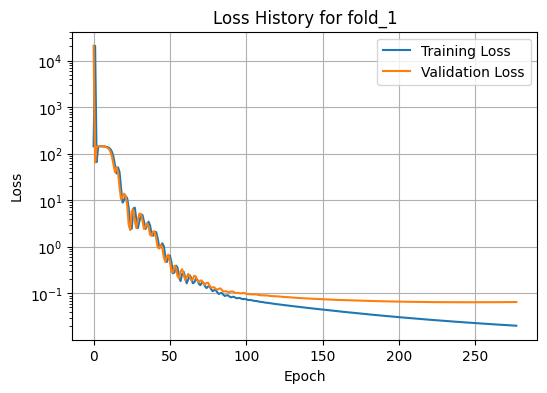

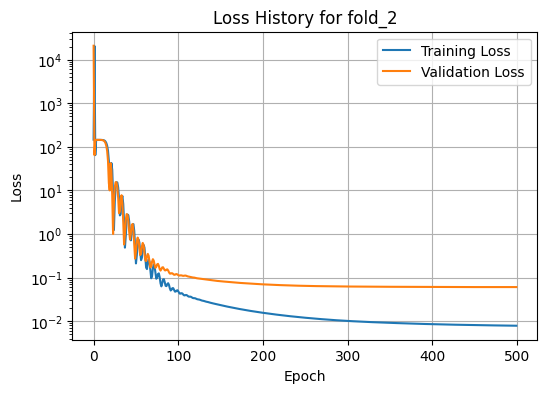

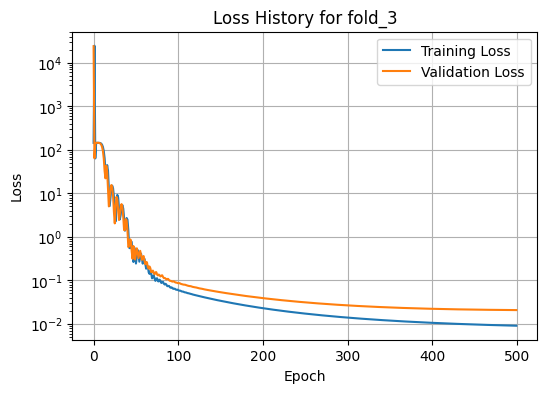

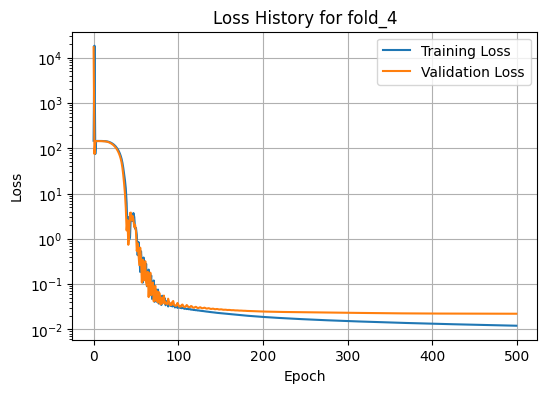

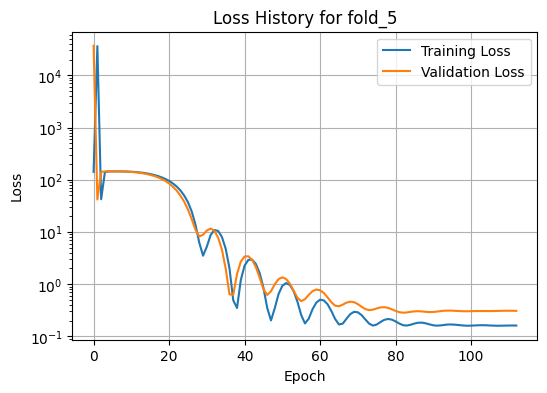

In [66]:
# the loss plot for each fold

if 'history' in locals():
    for fold, losses in history.items():
        plt.figure(figsize=(6, 4))
        plt.plot(losses['train_loss'], label='Training Loss')
        plt.plot(losses['val_loss'], label='Validation Loss')
        plt.title(f'Loss History for {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log') # Set y-axis to logarithmic scale
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Run the k_fold function first to generate the history.")

In [70]:
best_model = trained_models[3]

# Preprocess the validation data
val_data_processed = get_dataloader(val, training=False) # Use get_dataloader for tensor conversion

# Make predictions
predictions = best_model.predict(val_data_processed)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [71]:
# Ensure predictions are in the correct format (numpy array and flat)
predictions = tf.exp(predictions).numpy().flatten()

# Create a submission DataFrame
submission_df = pd.DataFrame({'Id': data_val['Id'], 'SalePrice': predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
